__Ссылка на наборы данных:__ https://drive.google.com/file/d/1j8zuKbI-PW5qKwhybP4S0EtugbPqmeyX/view?usp=sharing

__Задание 1:__ _Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы._

In [1]:
# !pip install missingno

In [2]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
%matplotlib inline

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


In [4]:
train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

In [5]:
train.describe()

target          var_0          var_1          var_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.100490      10.679914      -1.627622      10.715192   
std         0.300653       3.040051       4.050044       2.640894   
min         0.000000       0.408400     -15.043400       2.117100   
25%         0.000000       8.453850      -4.740025       8.722475   
50%         0.000000      10.524750      -1.608050      10.580000   
75%         0.000000      12.758200       1.358625      12.516700   
max         1.000000      20.315000      10.376800      19.353000   

               var_3          var_4          var_5          var_6  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        6.796529      11.078333      -5.065317       5.408949   
std         2.043319       1.623150       7.863267       0.866607   
min        -0.040200       5.074800     -32.562600       2.347300   
25%         5.254075       9.883175     -11.200350       4.767700   
50%         6.825000      11.108250      -4.833150       5.385100   
75%         8.324100      12.261125       0.924800       6.003000   
max        13.188300      16.671400      17.251600       8.447700   

               var_7          var_8  ...        var_190        var_191  \
count  200000.000000  200000.000000  ...  200000.000000  200000.000000   
mean       16.545850       0.284162  ...       3.234440       7.438408   
std         3.418076       3.332634  ...       4.559922       3.023272   
min         5.349700     -10.505500  ...     -14.093300      -2.691700   
25%        13.943800      -2.317800  ...      -0.058825       5.157400   
50%        16.456800       0.393700  ...       3.203600       7.347750   
75%        19.102900       2.937900  ...       6.406200       9.512525   
max        27.691800      10.151300  ...      18.440900      16.716500   

             var_192        var_193        var_194        var_195  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        1.927839       3.331774      17.993784      -0.142088   
std         1.478423       3.992030       3.135162       1.429372   
min        -3.814500     -11.783400       8.694400      -5.261000   
25%         0.889775       0.584600      15.629800      -1.170700   
50%         1.901300       3.396350      17.957950      -0.172700   
75%         2.949500       6.205800      20.396525       0.829600   
max         8.402400      18.281800      27.928800       4.272900   

             var_196        var_197        var_198        var_199  
count  200000.000000  200000.000000  200000.000000  200000.000000  
mean        2.303335       8.908158      15.870720      -3.326537  
std         5.454369       0.921625       3.010945      10.438015  
min       -14.209600       5.960600       6.299300     -38.852800  
25%        -1.946925       8.252800      13.829700     -11.208475  
50%         2.408900       8.888200      15.934050      -2.819550  
75%         6.556725       9.593300      18.064725       4.836800  
max        18.321500      12.000400      26.079100      28.500700  

[8 rows x 201 columns]

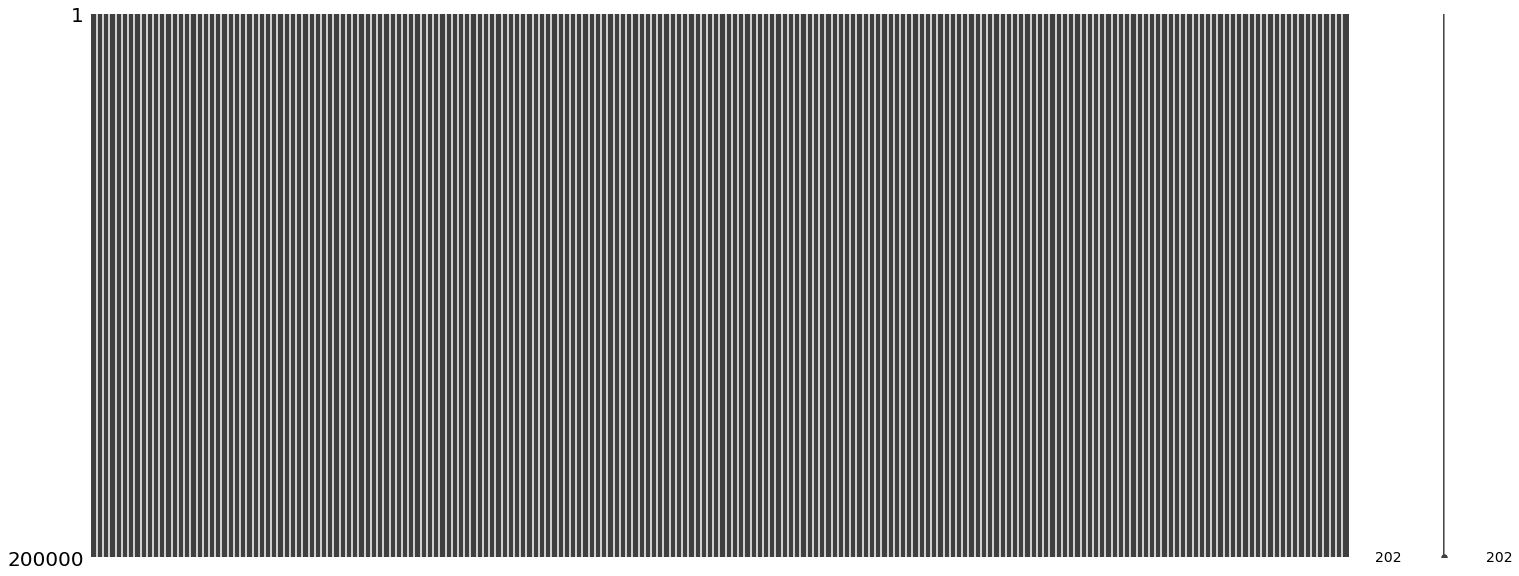

In [6]:
msno.matrix(train);

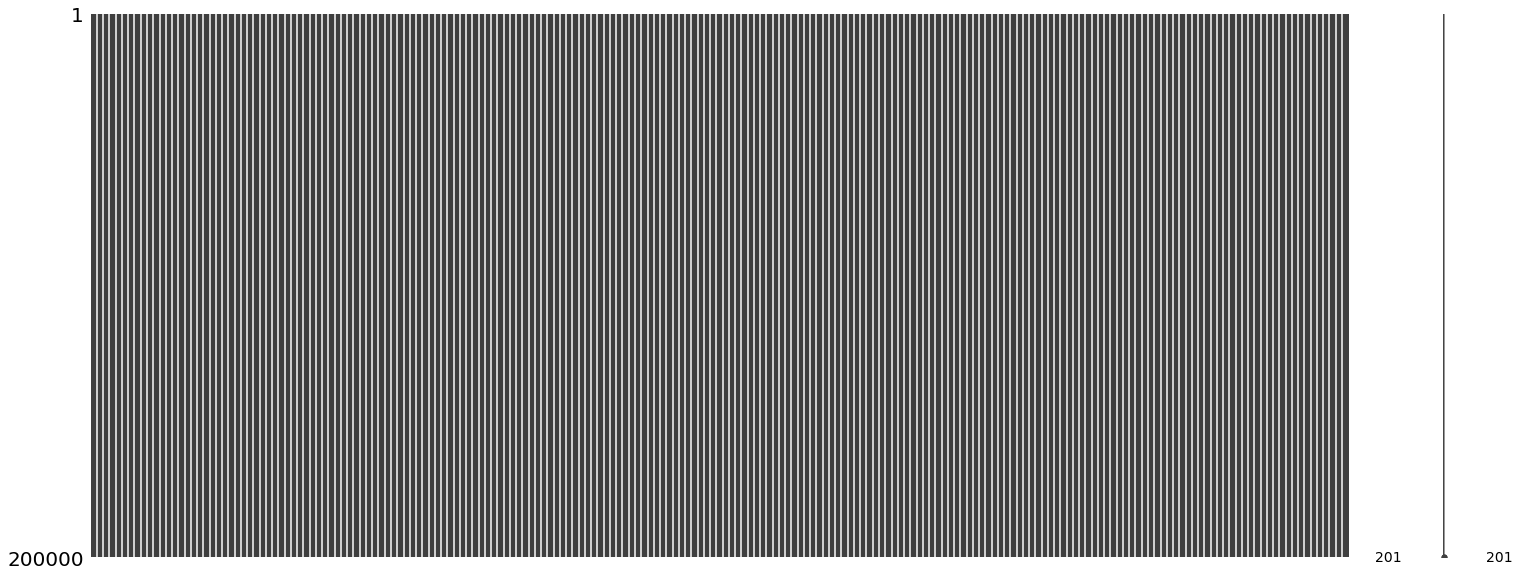

In [7]:
msno.matrix(test);

In [8]:
def count_nan(df):
    flag = True
    for col in df.columns:
        nan_count = df.shape[0] - df[col].isnull().sum()
        if not nan_count:
            return f"{col}: {nan_count} nan"
            flag = False

    return 'No NaN values' if flag else ''


print(f"Train: {count_nan(train)}")
print(f"Test: {count_nan(test)}")

Train: No NaN values
Test: No NaN values


In [9]:
train.dtypes.value_counts()

float64    200
int64        1
object       1
dtype: int64

In [10]:
print(train.select_dtypes(include = ['int64', 'object']).head())

   ID_code  target
0  train_0       0
1  train_1       0
2  train_2       0
3  train_3       0
4  train_4       0


In [11]:
train.select_dtypes(include = ['object']).nunique()

ID_code    200000
dtype: int64

In [12]:
print(train.ID_code.head(), '\n')
print(test.ID_code.head())

0    train_0
1    train_1
2    train_2
3    train_3
4    train_4
Name: ID_code, dtype: object 

0    test_0
1    test_1
2    test_2
3    test_3
4    test_4
Name: ID_code, dtype: object


Датасеты "train" и "test" содержат по 200000 наблюдений каждый, пропуски отсутствуют. Сравнивая квартили с максимальными и минимальными значениями переменных, можно предположить, что присутсвуют выбросы, но необходим дальнейший анализ. "ID_code" дублирует индексы, от этой переменной можно в дальнейшем избавиться. Все переменные, помимо "ID_code", имеют числовые значения.

__Задание 2:__ _Сделать базовый анализ целевой переменной, сделать выводы_

In [13]:
train.target.unique()

array([0, 1], dtype=int64)

In [14]:
print(train.target.value_counts(), '\n', '-'*30)
print(train.target.value_counts(normalize=True))

0    179902
1     20098
Name: target, dtype: int64 
 ------------------------------
0    0.89951
1    0.10049
Name: target, dtype: float64


Целевая переменная бинарная, значит стоит задача классификации. Наблюдается дисбаланс классов (90/10).

__Задание 3:__ _Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы_

Распределение признаков в зависимости от значения целевой переменной


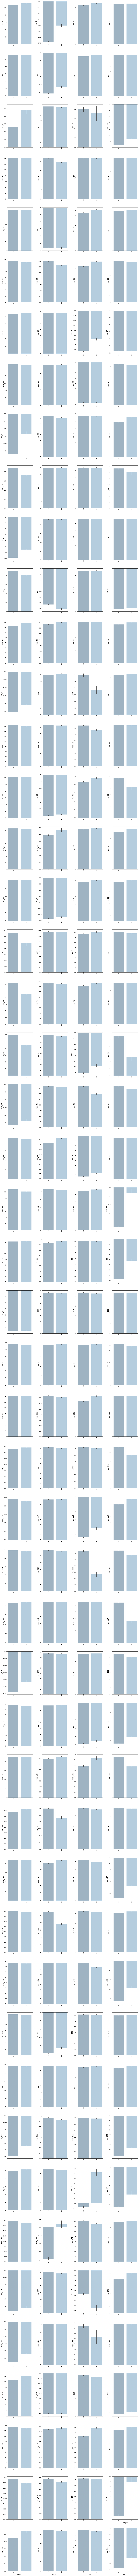

In [15]:
N_COLS = 4
fig = plt.figure(figsize=(20, 120))
print('Распределение признаков в зависимости от значения целевой переменной')
features = train.select_dtypes(exclude=['int64', 'object']).columns
N_ROWS = len(features)//N_COLS

for plot_number, feature in enumerate(features, start=1):
    plt.subplot(N_ROWS, N_COLS, plot_number)
    sns.barplot(x=train['target'].values, y=train[feature].values, alpha=0.5, palette='Blues_d')
    plt.ylabel(feature, size=14)

    if N_ROWS*N_COLS - N_COLS <= plot_number:
        plt.xlabel("target", size=14)

plt.subplots_adjust(wspace=0.35, hspace=0.2)

In [16]:
N_COLS = 2
N_ROWS = len(features)//N_COLS
print('Распределение признаков для обучающей и тестовой выборки')
fig = plt.figure(figsize=(20, 800))


for num, feature in enumerate(features, start=1):
    plt.subplot(N_ROWS, N_COLS, num)
    sns.kdeplot(train[feature], color="blue", label="train", alpha=.5)
    sns.kdeplot(test[feature], color="green", label="test", alpha=.5)
    plt.xlabel(feature, size=14)
    
plt.subplots_adjust(wspace=0.3, hspace=0.4)

Распределение признаков для обучающей и тестовой выборки


Распределение признаков в зависимости от значения целевой переменной в большей части признаков похожее, но есть признаки, где это не так, что может быть вызвано  дисбалансом классов. Потребуется дальнейший анализ. Распределения признаков для обучающей и тестовой выборок не имеют значимых различий. В дальнейшем можно проверить отдельные признаки, к примеру 'var_141', на различия по критерию Уилкоксона-Манна-Уитни.

__Задание 4:__ _Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы_

Распределение основных статистик признаков train


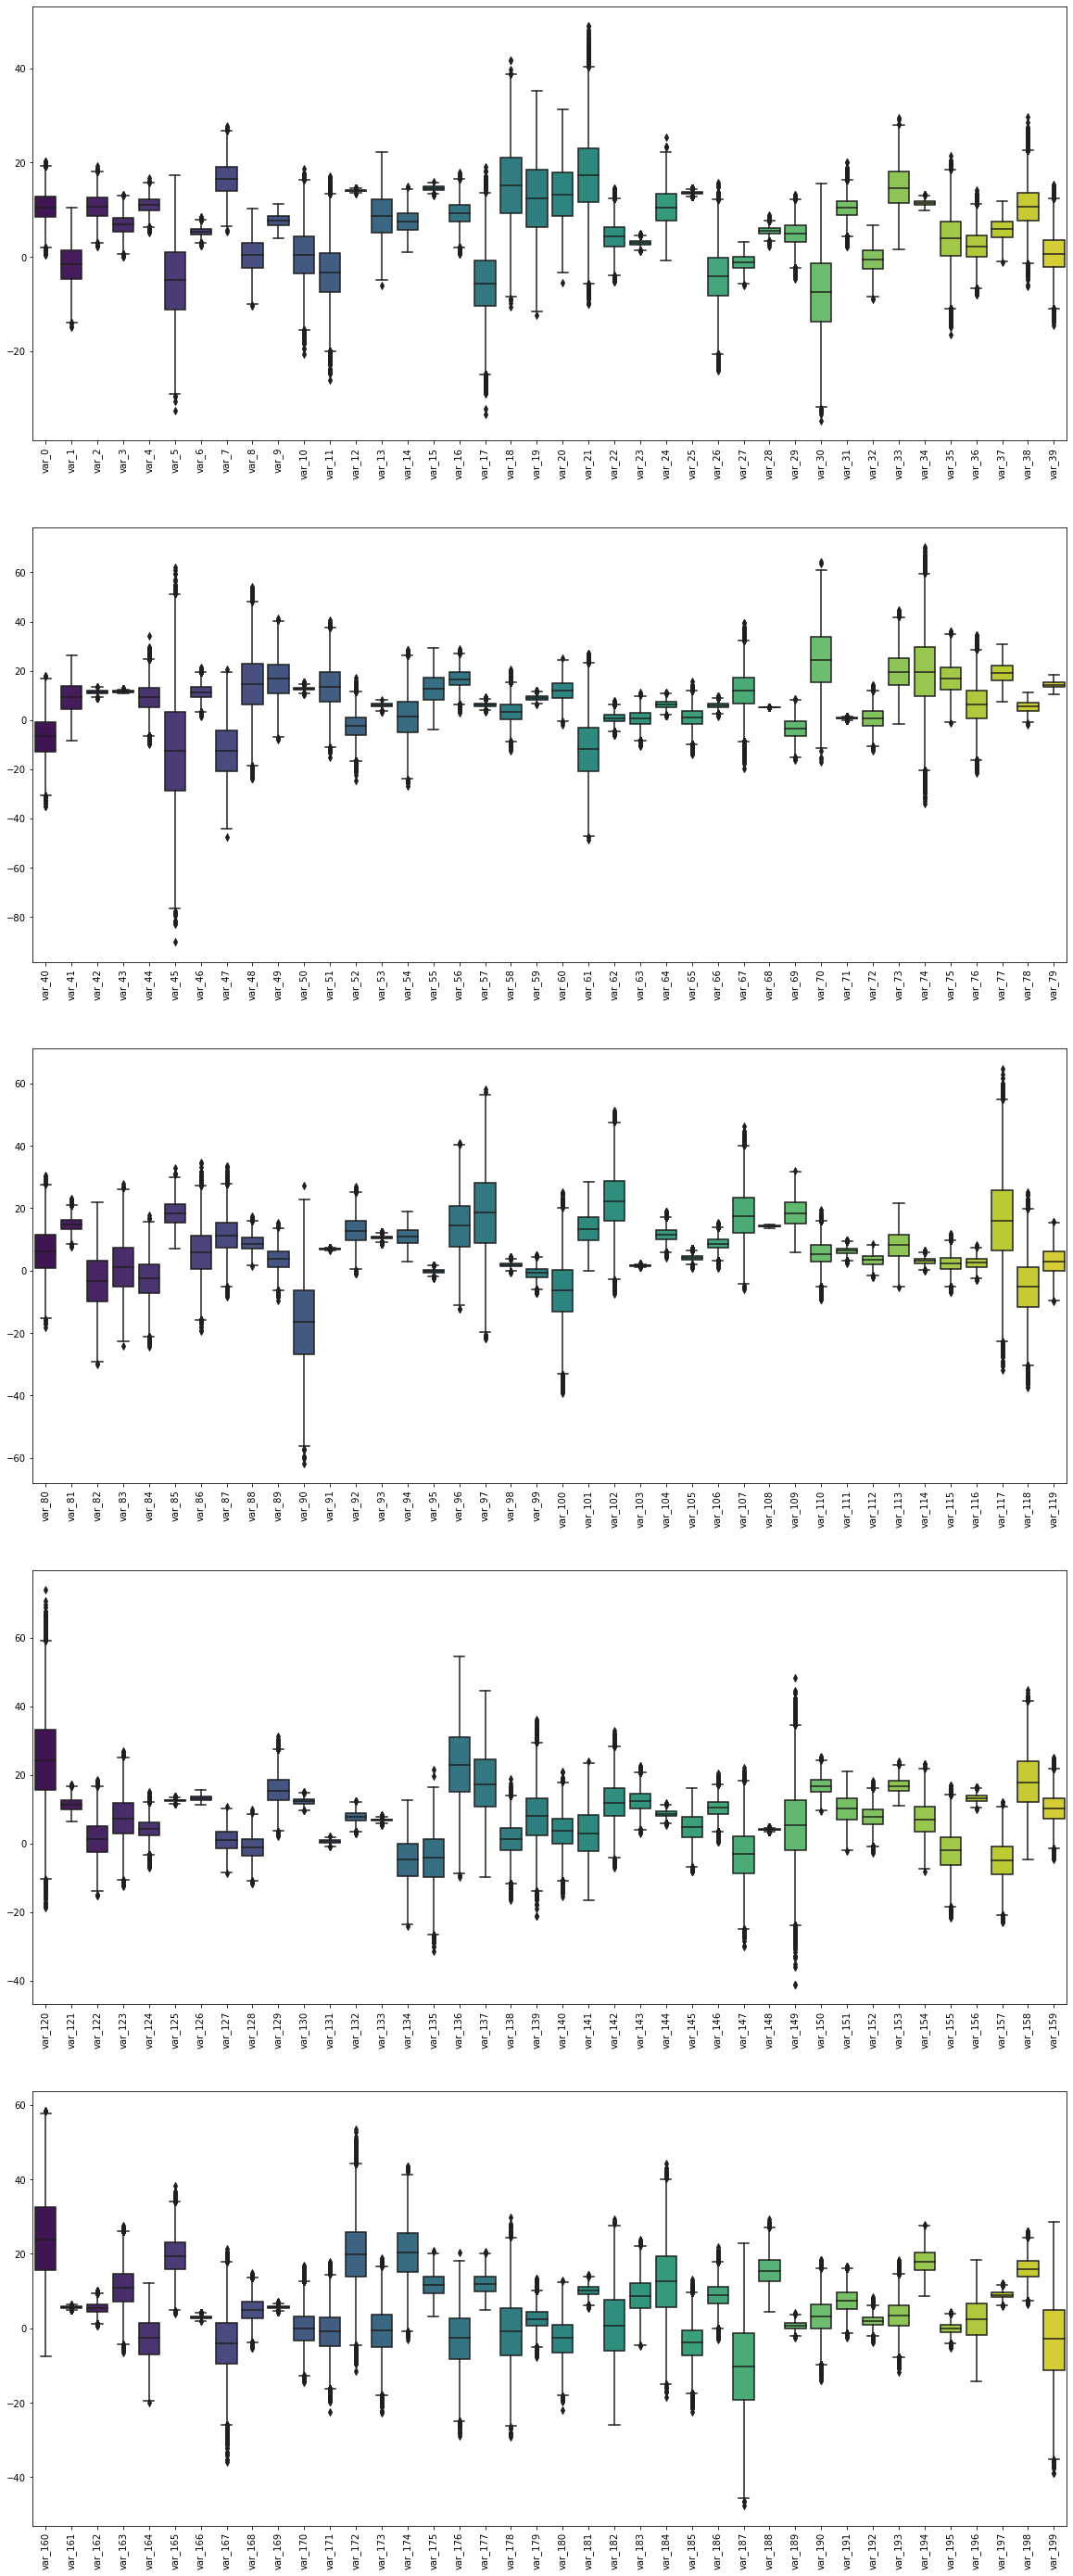

In [17]:
N_PLOTS = 5
print('Распределение основных статистик признаков train')
fig = plt.figure(figsize=(20, 50))


for plot_n, i in enumerate(range(0, len(features), len(features)//N_PLOTS), start=1):
    plt.subplot(N_PLOTS, 1, plot_n)
    sns.boxplot(data=train[features[i:i+len(features)//N_PLOTS]], palette="viridis", orient="v")
    x=plt.xticks(rotation=90)

Распределение основных статистик признаков test


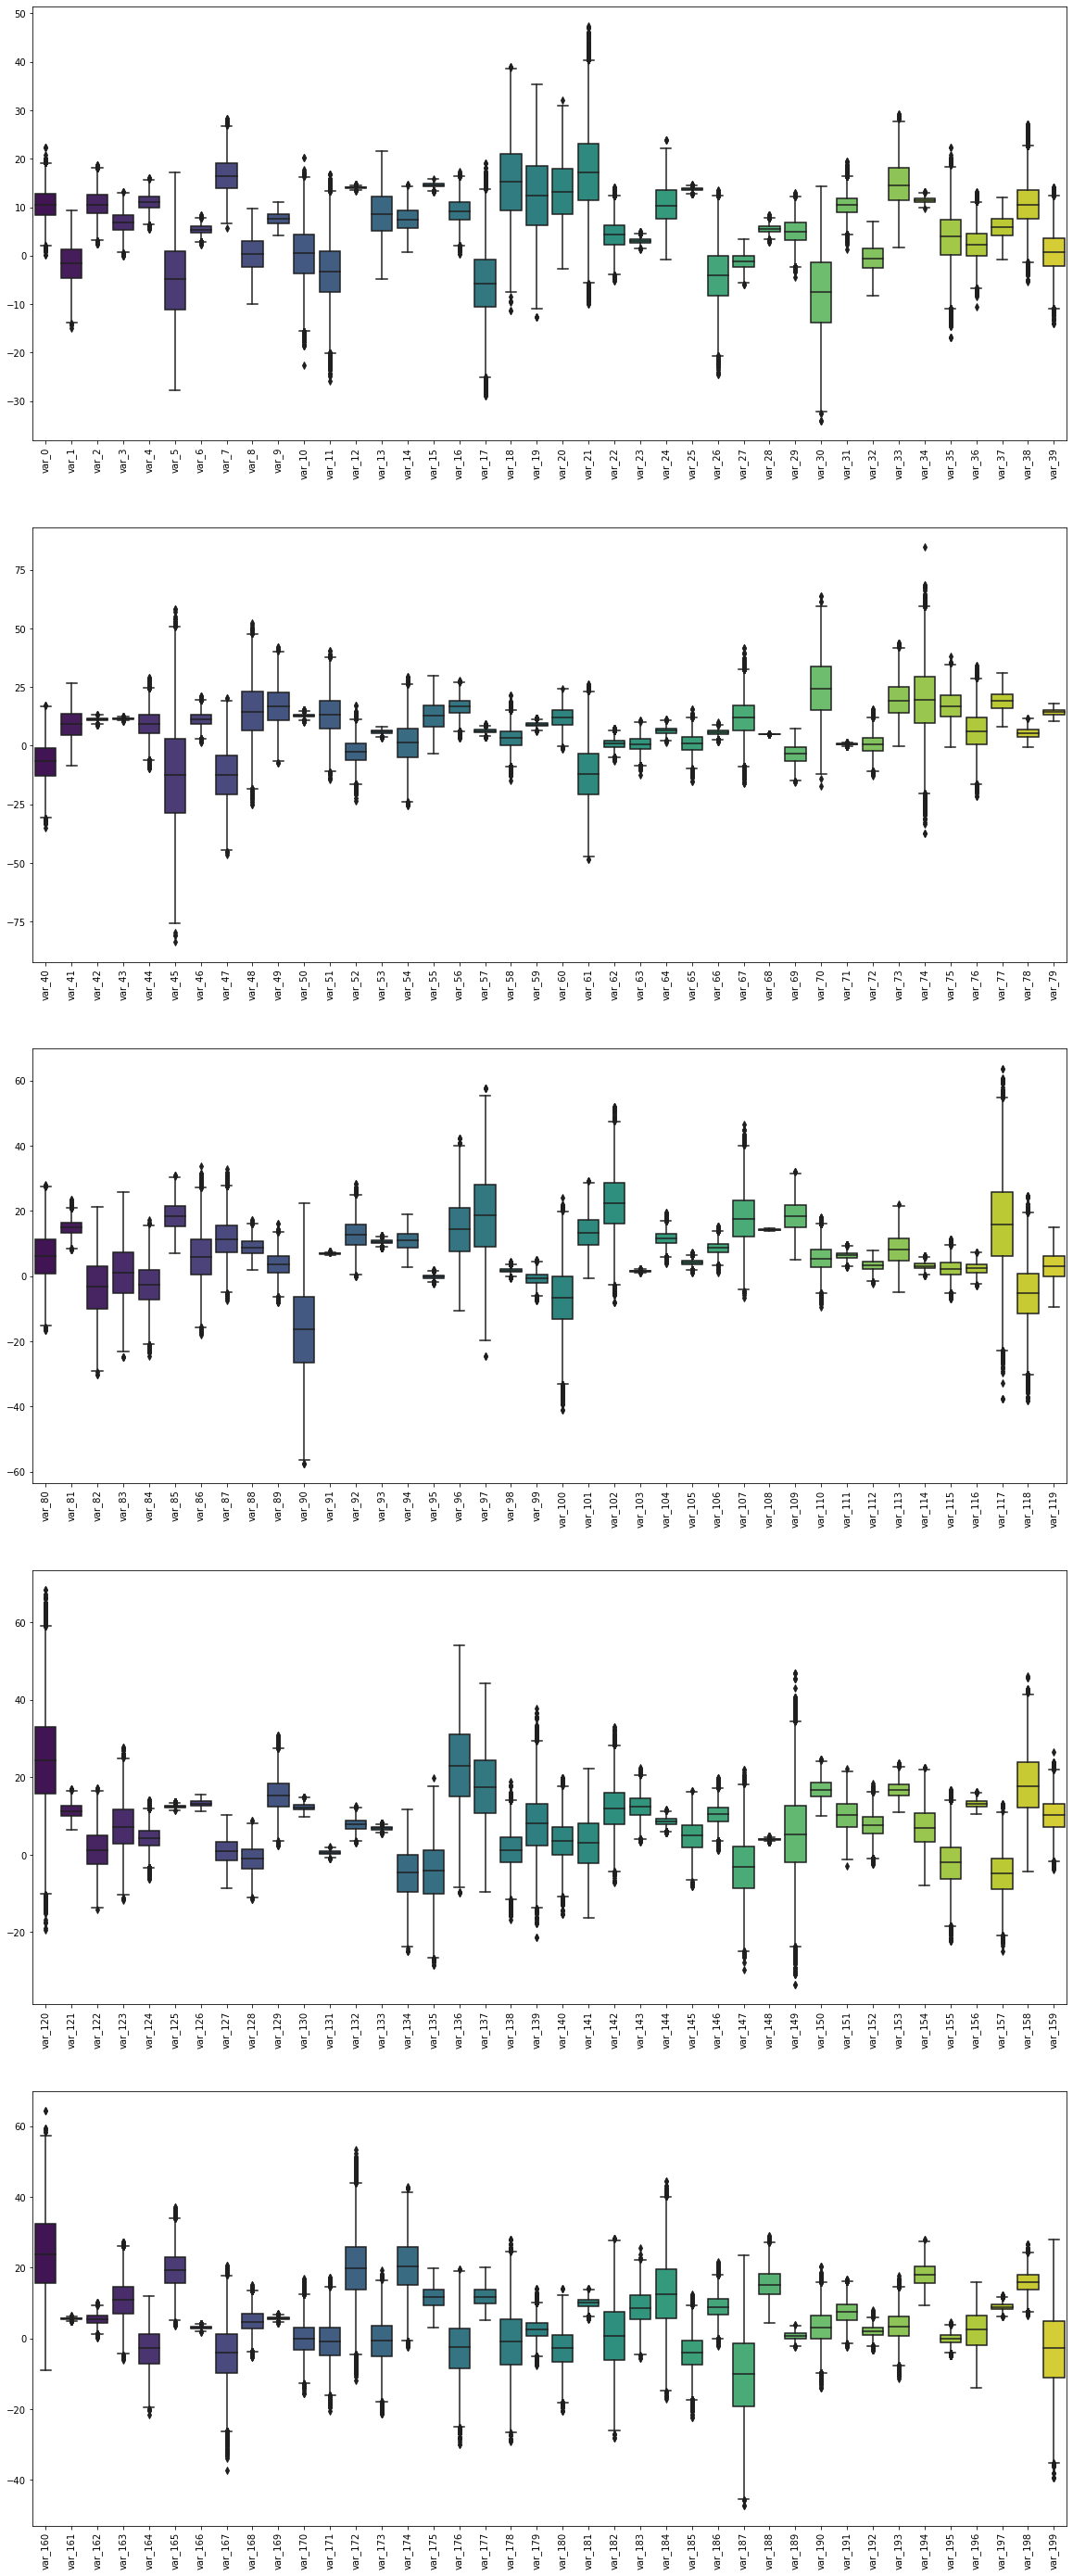

In [18]:
N_PLOTS = 5
print('Распределение основных статистик признаков test')
fig = plt.figure(figsize=(20, 50))


for plot_n, i in enumerate(range(0, len(features), len(features)//N_PLOTS), start=1):
    plt.subplot(N_PLOTS, 1, plot_n)
    sns.boxplot(data=test[features[i:i+len(features)//N_PLOTS]], palette="viridis", orient="v")
    x=plt.xticks(rotation=90)

Некоторые признаки имеют очень большую дисперсию, что говорит нам о выбросах. Test и train имеют похожие характеристики.

__Задание 5:__ _Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?_

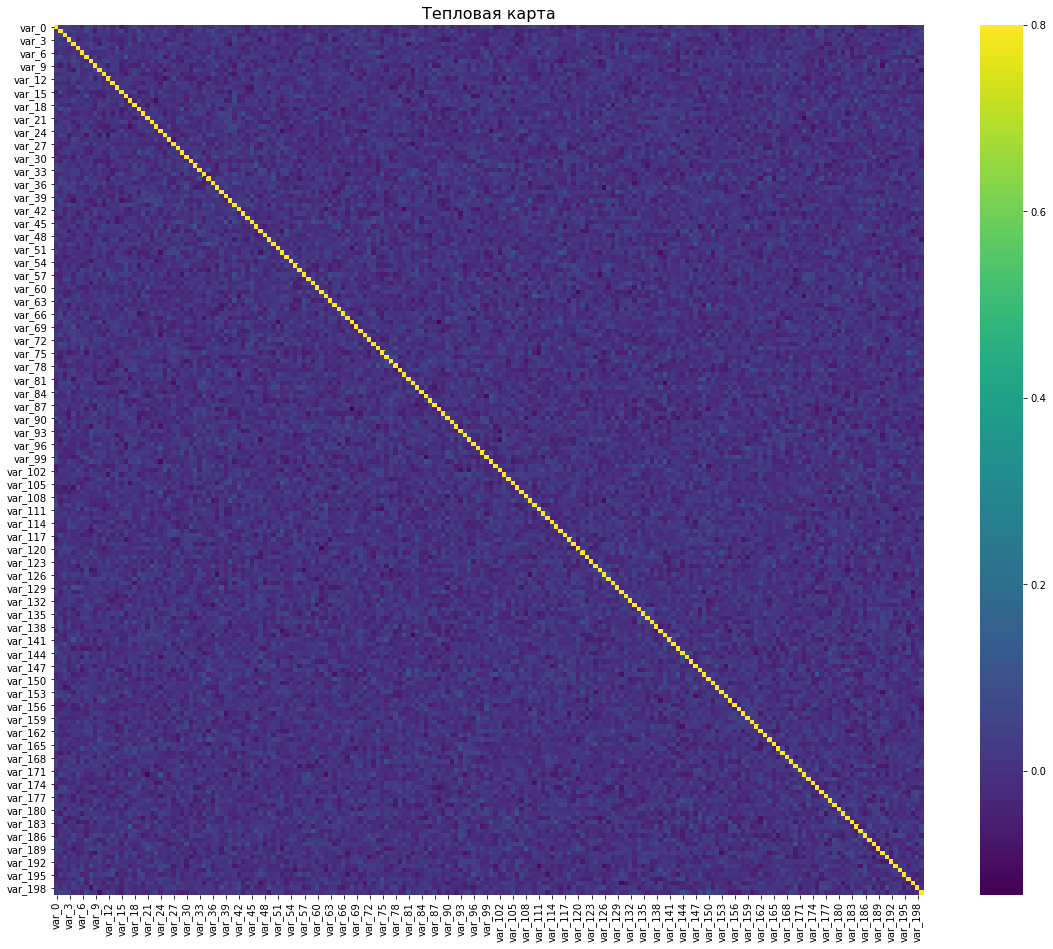

In [19]:
fig, axes = plt.subplots(figsize = (20, 16))
plt.title("Тепловая карта", y=1, size=16)
sns.heatmap(train[features][:1000].corr(), square=True, vmax=0.8, cmap="viridis");

(Матрица корреляций построенна на части данных для уменьшения однородности поля)
Ярковыраженной линейной зависимости между признаками нет.

__Задание 6:__ _Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной._

In [20]:
parameters = {"max_depth": 8, "n_estimators": 25, "random_state": 27, "n_jobs": 4}

forest = RandomForestRegressor(**parameters)
forest.fit(train[features], train.target);

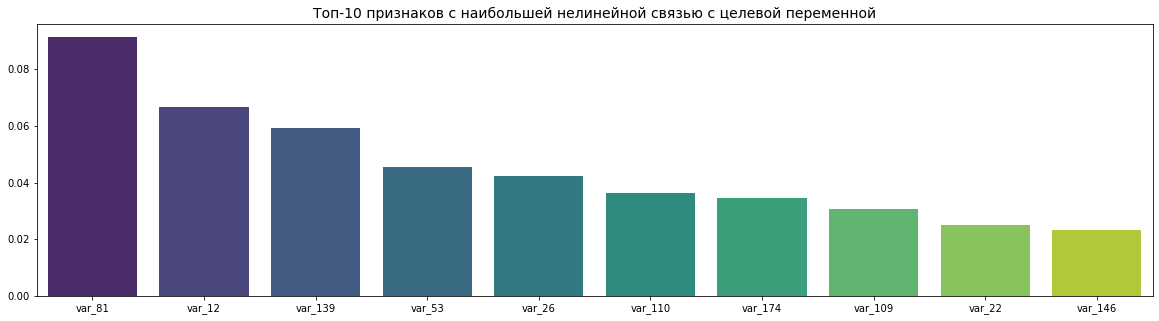

In [21]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train[features].columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("Топ-10 признаков с наибольшей нелинейной связью с целевой переменной", size=14);

__Задание 7:__ _Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы._

In [22]:
class PSI(BaseEstimator, TransformerMixin):
    
    def __init__(self,
                 threshold: float,
                 categorical_features: Optional[List[str]] = None,
                 bin_type: str = "quantiles",
                 min_value: float = 0.005,
                 n_bins: int = 20):

        self.threshold = threshold
        self.categorical_features = categorical_features
        self.min_value = min_value
        self.n_bins = n_bins
        if bin_type in ["quantiles", "bins"]:
            self.bin_type = bin_type
        else:
            raise ValueError(
                "Incorrect bin_type value. Expected 'quantiles' or 'bins', "
                f"but {bin_type} is transferred."
            )
        self.scores = {}

    def calculate_bins(self, data: pd.Series) -> np.array:
        
        if self.bin_type == "quantiles":
            bins = np.linspace(0, 100, self.n_bins + 1)
            bins = [np.nanpercentile(data, x) for x in bins]

        else:
            bins = np.linspace(data.min(), data.max(), self.n_bins + 1)

        return np.unique(bins)

    def calculate_psi_in_bin(self, expected_score, actual_score) -> float:

        if expected_score == 0:
            expected_score = self.min_value
        if actual_score == 0:
            actual_score = self.min_value

        value = (expected_score - actual_score)
        value = value * np.log(expected_score / actual_score)

        return value

    def calculate_psi(self, expected: pd.Series, actual: pd.Series, bins) -> float:

        expected_score = np.histogram(expected.fillna(-9999), bins)[0]
        expected_score = expected_score / expected.shape[0]

        actual_score = np.histogram(actual.fillna(-9999), bins)[0]
        actual_score = actual_score / actual.shape[0]

        psi_score = np.sum(
            self.calculate_psi_in_bin(exp_score, act_score)
            for exp_score, act_score in zip(expected_score, actual_score)
        )

        return psi_score

    def calculate_numeric_psi(self, expected: pd.Series, actual: pd.Series) -> float:

        bins = self.calculate_bins(expected)
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def calculate_categorical_psi(self, expected: pd.Series, actual: pd.Series) -> float:

        bins = np.unique(expected).tolist()
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def fit(self, X, y=None):

        missed_columns = list(set(X.columns) - set(y.columns))

        if missed_columns:
            raise MissedColumnError(
                f"Missed {list(missed_columns)} columns in data.")

        if self.categorical_features:
            numeric_features = list(
                set(X.columns) - set(self.categorical_features)
            )
            for feature in self.categorical_features:
                self.scores[feature] = self.calculate_categorical_psi(
                    X[feature], y[feature]
                )
        else:
            numeric_features = X.columns

        for feature in tqdm(numeric_features):
            self.scores[feature] = self.calculate_numeric_psi(
                X[feature], y[feature]
            )
        return self

    def transform(self, X, y=None) -> pd.DataFrame:

        check_is_fitted(self, "scores")
        scores = pd.Series(self.scores)
        scores = pd.DataFrame({"Variable": scores.index, "PSI": scores.values})
        scores["Selected"] = np.where(scores.PSI < self.threshold, 1, 0)
        scores = scores.sort_values(by="PSI")

        mask = scores["Selected"] == 1
        self.used_features = scores.loc[mask, "Variable"].tolist()

        return scores.reset_index(drop=True)

In [23]:
features_to_score = features.tolist()
psi = PSI(threshold=0.01)

psi.fit_transform(
    X=train[features_to_score],
    y=test[features_to_score]
)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]<ipython-input-22-733bf9d2b199>:54: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  psi_score = np.sum(
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:23<00:00,  8.50it/s]


Variable       PSI  Selected
0    var_154  0.000085         1
1    var_156  0.000132         1
2      var_5  0.000138         1
3    var_148  0.000150         1
4     var_35  0.000151         1
..       ...       ...       ...
195  var_124  0.000615         1
196   var_79  0.000628         1
197  var_162  0.000639         1
198   var_29  0.000667         1
199   var_90  0.000694         1

[200 rows x 3 columns]

Kolmogorov-Smirnov Test


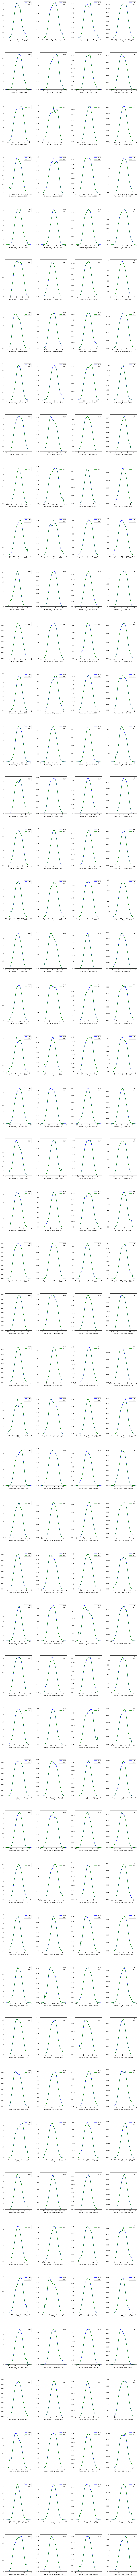

In [24]:
N_COLS = 4
N_ROWS = len(features)//N_COLS
print('Kolmogorov-Smirnov Test')
fig = plt.figure(figsize=(20, 400))
statistics_array = []

for num, feature in enumerate(features, start=1):
    statistic, pvalue = ks_2samp(
    train[feature].sample(500), test[feature].sample(500))
    statistics_array.append(statistic)
    
    plt.subplot(N_ROWS, N_COLS, num)
    sns.kdeplot(train[feature], color="blue", label="train")
    sns.kdeplot(test[feature], color="green", label="test")
    plt.xlabel(f"feature: {feature}, p-value: {round(statistic, 3)}")
    
plt.subplots_adjust(wspace=0.3, hspace=0.4)

Можно утверждать, что train и test выборки идентичны.